# Decision Tree and Random Forest

# Decision Tree

Decision Tree เป็น supervised machine learning algorithm ที่ใช้ในงานการจำแนกและทำนายข้อมูล
โครงสร้างของ decision tree คล้ายกับต้นไม้ที่มีลำต้นและแตกกิ่งตามเงื่อนไขที่ตั้งไว้ โดยในที่นี้เงื่อนไขจะเป็นเงื่อนไขเชิงตรรกะในลักษณะ มีรูปแบบเป็น $x_j < x_0$ or $x_j \ge x_0$ โดย $x_j$ คือ feature ที่ $j$ ของชุดข้อมูล และ $x_0$ คือ ค่าเกณฑ์ที่ใช้ในการแบ่งกลุ่ม ซึ่งมีความจำเพาะกับชุดข้อมูลที่ใช้พัฒนาโมเดลและถูกคัดเลือกให้เพิ่ม information gain หรือ ลด impurity ของกลุ่มข้อมูลเพื่อคงประสิทธิภาพของโมเดล  จากเงื่อนไขแรก ชุดข้อมูลจะถูกแบ่งเป็นกลุ่มย่อยๆ เพื่อเข้าสู่เงื่อนไขต่อไป ข้อมูลจะถูกแบ่งเป็นกลุ่มเล็กลงเรื่อยๆ  กระบวนการเช่นนี้จะเกิดขึ้นซ้ำไปเรื่อยๆ จนกว่าจะเกิดสถานการณ์ดังต่อไปนี้
1. ข้อมูลในกลุ่มย่อยเป็นคลาสเดียวกันหรือมีค่าเท่ากัน โมเดลจึงไม่ต้องสร้างเงื่อนไขใหม่ในการแตกกิ่งต่อไป
2. เงื่อนไขใหม่ไม่ก่อให้เกิด information gain หรือ ลด impurity
3. โมเดลได้แตกกิ่งก้านไปจนถึงข้อจำกัดของ hyperparameters ที่ตั้งไว้

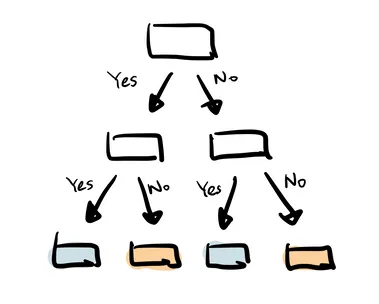 [ที่มา](https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501)

เราสามารถสร้างโมเดล decision tree สำหรับ classification problem ด้วย [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) ในไลบรารี่ `scikit-learn` โดยฟังค์ชันที่ใช้ประเมินคุณภาพของเงื่อนไขในการแตกกิ่งต้นไม้ ได้แก่  Gini impurity (default), Shannon entropy หรือ $\log$ loss ซึ่งเทียบเท่ากับการประเมิน information gain สามารถศึกษาเพิ่มเติมได้ที่
 [classification criteria](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)

 โมเดล decision tree สามารถทำได้ทั้งงาน classification และ regression โดยในบทเรียนนี้ เราจะแสดงการทำงานของโมเดลกับ classification problem

เพื่อศึกษาการทำงานของโมเดล decision tree เราจะลองสร้างชุดข้อมูลที่ประกอบไปด้วย จำนวน $n=200$ จุด โดยประกอบด้วย 2 features และ $y$ มีค่า 0 หรือ 1 (2-class dataset for binary classification)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
RANDOM_SEED = 2566

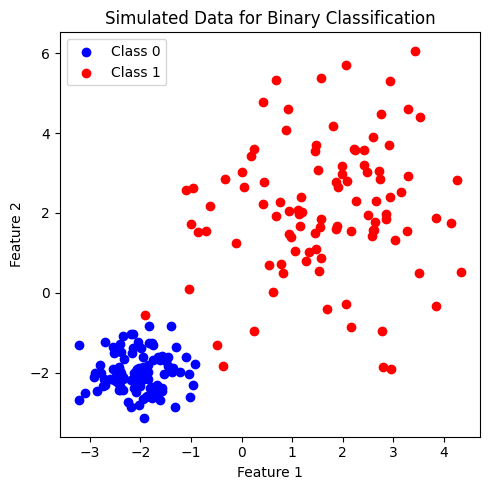

In [ ]:
def generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples):
    # สร้างชุดข้อมูลแบบ multi-class
    # ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
    np.random.seed(RANDOM_SEED)

    # กำหนด จำนวน features
    n_features = 2

    #  สร้างข้อมูล x สำหรับแต่ละคลาส
    x_data = []
    for label in range(n_classes):
        _ = np.random.normal(mean_class[label], std_class[label], (n_samples, n_features))
        x_data.append(_)

    # สร้างข้อมูล y หรือ labels สำหรับแต่ละคลาส
    y_data = []
    y_data.append(np.zeros(n_samples))
    for label in range(1, n_classes):
        y_data.append(label*np.ones(n_samples))

    # รวมข้อมูล x และ y จากทุกคลาส
    x = np.vstack((x_data))
    y = np.hstack(y_data)

    return x, y

# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-2], [2,2]]
std_class  = [[0.5,0.5], [1.5,1.5]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

ข้อมูลที่สร้างขึ้นมีการแบ่งกลุ่มค่อนข้างชัดเจน  โดยเป็นข้อมูลชุดเดียวกับที่เราใช้พัฒนาโมเดล logistic regression และโมเดล k-NN ในบทเรียนก่อนหน้า โดยโมเดล logistic regression ได้เลือก linear decision boundary ที่สามารถจำแนกคลาสได้ดีที่สุด ในขณะที่ decision boundary ของโมเดล k-NN มีลักษณะ non-linear ตามการกระจายตัวของข้อมูล  โดยเราสามารถคาดการณ์ได้ว่า หากเราใช้โมเดล support vector mechine มาจำแนกชุดข้อมูลนี้ decision boundary ก็จะมีลักษณะได้ทั้ง linear หรือ non-linear ตามที่ kernel ที่เลือกใช้


เราจะให้โมเดล decision tree เรียนรู้ข้อมูลชุดนี้ โดยใช้ default hyperparameters นั่นคือ โมเดลสามารถแต่กิ่งไปได้เรื่อยๆ จน Gini imputity กลายเป็น 0 ซึ่งหมายความว่า ข้อมูลกลุ่มย่อยสุดท้ายมีคลาสเดียวกัน



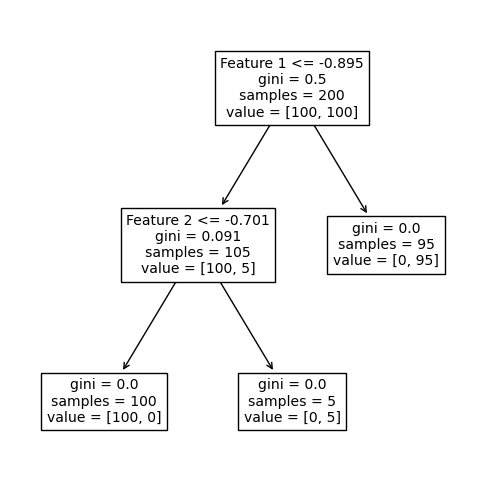

In [ ]:
# สร้างชุดโมเดล
clf = DTC(random_state=RANDOM_SEED)

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# Plot Decision Tree
plt.figure(figsize = (5,5))
tree.plot_tree(clf, feature_names=['Feature 1','Feature 2'])
plt.tight_layout()
plt.show()

พบว่า ต้นไม้มีการตัดสินใจด้วย 2 เงื่อนไข คือ
1. Feature 1 มีค่าน้อยกว่า -0.895
2. Feature 2 มีค่าน้อยกว่า -0.701

โดยเมื่อพิจารณาข้อมูลกลุ่มย่อยที่ปลายกิ่ง พบว่า ค่า impurity (gini) เป็นศูนย์ และ กลุ่มข้อมูลย่อย (samples) อยู่ในคลาสเดียวกัน (ค่า value ไม่เป็นศูนย์ที่คลาสใดคลาสหนึ่ง)

กล่องเงื่อนไขเหล่านี้ เรียกว่า *decision node* และกล่องปลายกิ่งที่มีข้อมูลของกลุ่มย่อยสุดท้าย เรียก *terminal node*

ต่อไปเราจะแสดง decision boundary ของโมเดล decision tree

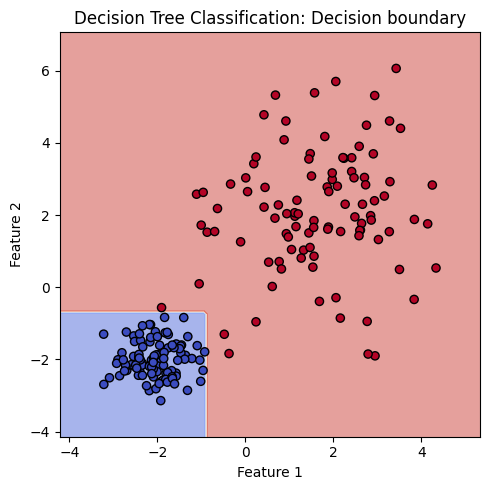

In [ ]:
# plot the decision boundary
plt.figure(figsize = (5,5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       response_method="predict",
                                       cmap=plt.cm.coolwarm,
                                       alpha=0.5,
                                       ax=ax,
                                       xlabel='Feature 1',
                                       ylabel='Feature 2'
                                       )
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
plt.title('Decision Tree Classification: Decision boundary')
plt.tight_layout()
plt.show()

ภาพแสดง decision boundary ที่มีลักษณะเป็นกล่อง  ซึ่งเกิดจากการสร้างเงื่อนไขในการตัดสินใจ 2 เงื่อนไขที่แสดงก่อนหน้านี้

ต่อไปเราจะลองสร้างข้อมูลที่จำแนกคลาสได้ยากขึ้น

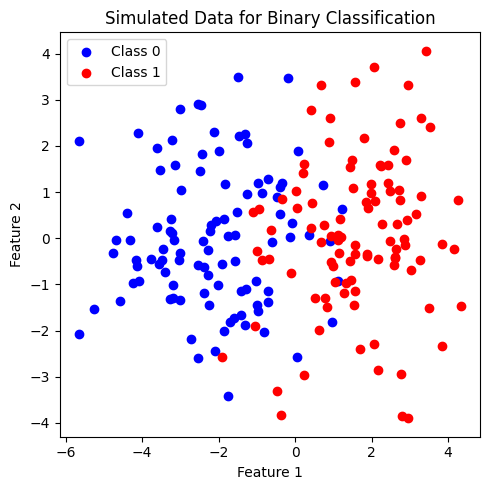

In [ ]:
# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-0], [2,0]]
std_class  = [[1.5,1.5], [1.5,1.5]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

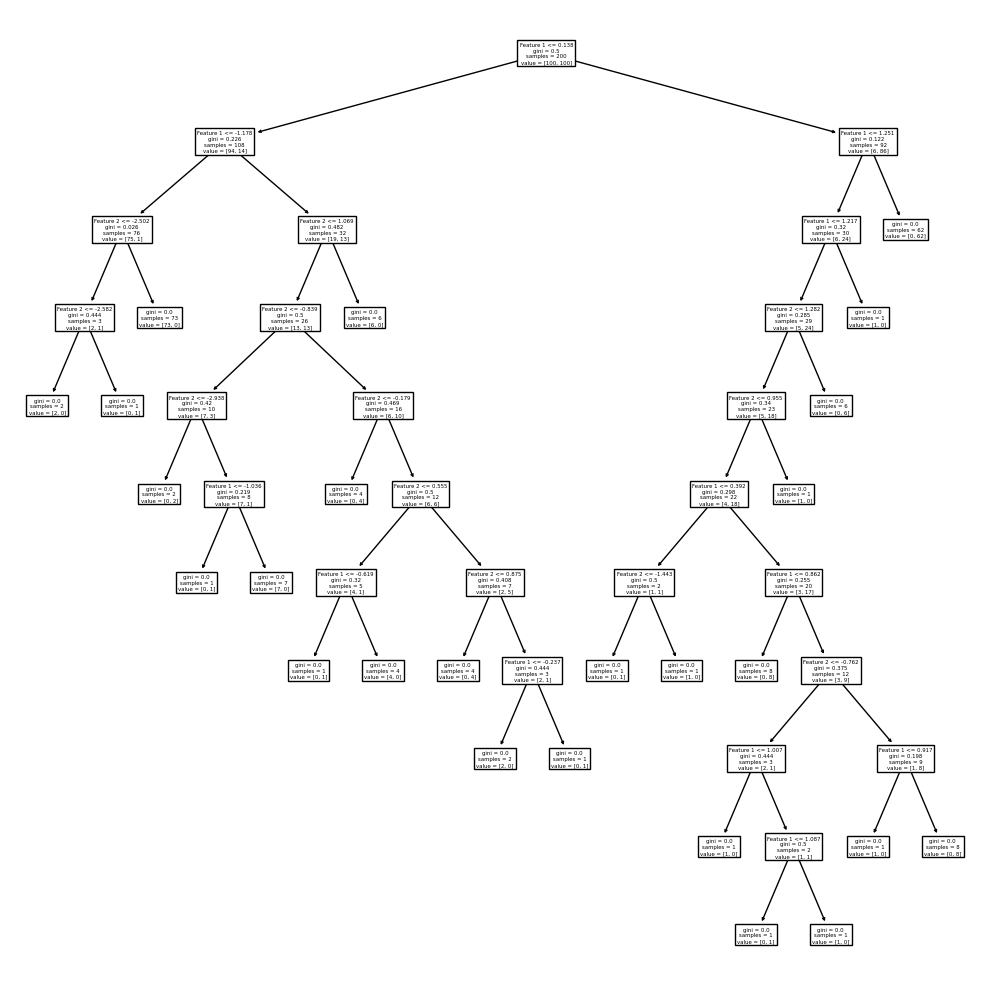

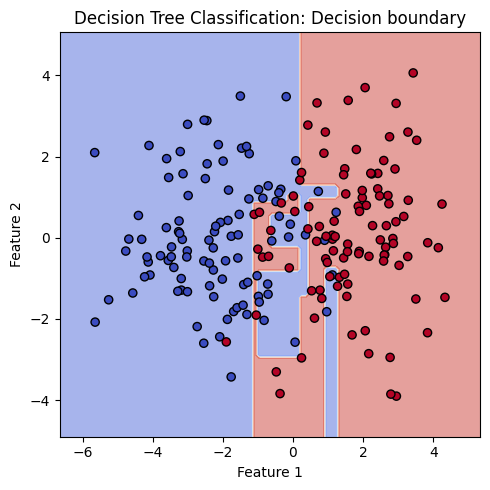

In [ ]:
# สร้างชุดโมเดล
clf = DTC(random_state=RANDOM_SEED)

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# Plot Decision Tree, showing decision path
plt.figure(figsize = (10,10))
tree.plot_tree(clf, feature_names=['Feature 1','Feature 2'])
plt.tight_layout()
plt.show()

# plot the decision boundary
plt.figure(figsize = (5,5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       response_method="predict",
                                       cmap=plt.cm.coolwarm,
                                       alpha=0.5,
                                       ax=ax,
                                       xlabel='Feature 1',
                                       ylabel='Feature 2'
                                       )
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
plt.title('Decision Tree Classification: Decision boundary')
plt.tight_layout()
plt.show()

จะเห็นได้ว่า โมเดล decision tree มีข้อดีที่สร้างเงื่อนไขตัดสินใจที่เข้าใจได้ง่ายและสามารถอธิบายการทำงานได้ชัดเจน แต่ในขณะเดียวกัน โมเดลก็มีข้อเสียที่มักเกิด overfitting (การที่โมเดลเรียนรู้มากเกินไปจนจดจำคำตอบ)   โดยเฉพาะเมื่อชุดข้อมูลมี noise มาก  ซึ่งสามารถแก้ไขเบื้องต้นโดยการปรับค่า hyperparameters ไม่ให้ต้นไม้แตกกิ่งมากจนเกินไป หรือ การทำ pruning ซึ่งเป็นกระบวนการลดขนาดของต้นไม้

ถึงแม้ว่าโมเดล decision tree มักเกิด overfitting แต่ก็เป็น algorith พื้นฐานในการพัฒนา machine learning algoriths หลายตัวที่ใช้อย่างแพร่หลายในปัจจุบัน เช่น Extra Tree, Random Forest, Gradient Boosting, XGBoost, CatBoost เป็นต้น ซึ่งได้รับการแก้ไข overfitting ด้วย Ensemble methods ต่างๆ  ซึ่งเราจะศึกษาโมเดล Random Forest เป็นลำดับต่อไป

# Random Forest

**Random forest (RF)** เป็นการทำงานร่วมกันของโมเดล decision tree หลายๆ ต้นผ่าน ensemble method ที่เรียกว่า *bagging* หรือ *bootstrap aggregating*

กระบวนการ Bagging เริ่มต้นด้วยการสร้าง bootstrap samples จากชุดข้อมูลที่มี ตามจำนวนโมเดล decision tree ที่ต้องการพัฒนา โดยใช้วิธีการสุ่มจุดข้อมูลโดยไม่แยกจุดข้อมูลที่ถูกเลือกออกมา  ทำให้ข้อมูลแต่ละจุดสามารถถูกเลือกได้หลายครั้งหรืออาจจะไม่ถูกเลือกเลย  วิธีการนี้จะทำให้เราได้ bootstrap samples ที่แตกต่างกันแต่มีขนาดเท่ากัน

จากนั้น เราจะนำ bootstrap samples มาใช้พัฒนาโมเดล decision tree ตามจำนวนที่ต้องการ เพื่อใช้จำแนกหรือคาดการณ์ข้อมูล โดยเราจะรวมผลลัพธ์จากแต่ละโมเดลเข้าด้วยกันโดยใช้ aggregating method เช่น การนับคะแนน vote คลาสที่มากที่สุดสำหรับ classification problem หรือ  การหาค่าเฉลี่ยผลลัพธ์สำหรับ regression problem

การทำ bagging ช่วยลดความผิดพลาดในการทำนายจาก overfitting โดยใช้ประโยชน์จากการเพิ่มความหลากหลายของ training data และโมเดลที่สร้างขึ้น นอกจากนี้ โมเดล random forest ยังสามารถให้คะแนนความสำคัญของ feature ในชุดข้อมูล  (feature importance)

โมเดล Random Forest สามารถทำได้ทั้งงาน classification และ regression โดยในบทเรียนนี้ เราจะแสดงการทำงานของโมเดลกับ classification problem

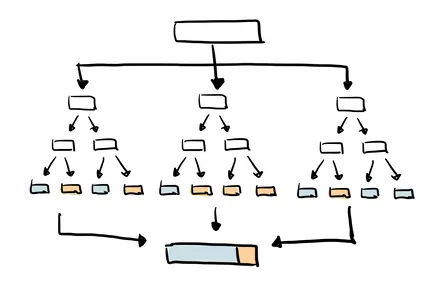

[ที่มา](https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501)

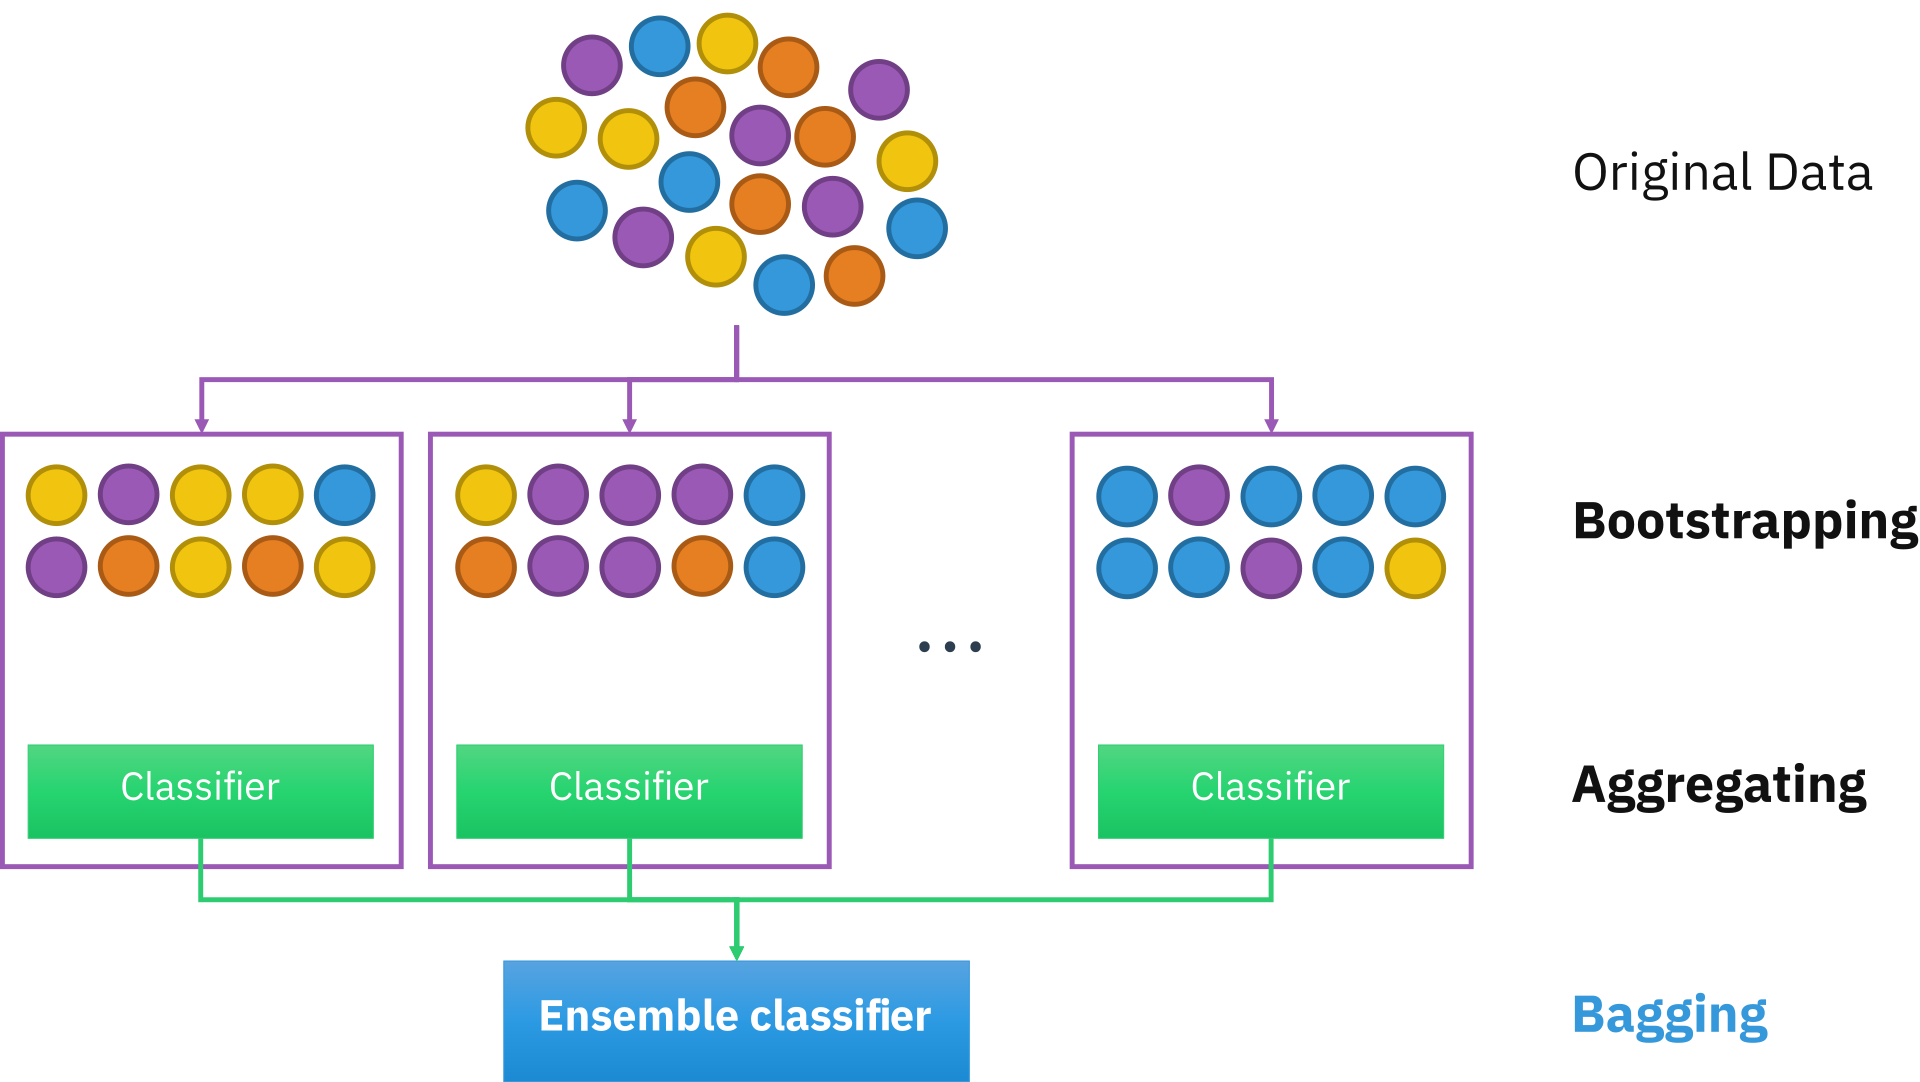

Ensemble baggin ที่มา: wikipedia.com

## Random Forest เมื่อปรับค่า 'n_estimators' (จำนวนต้นไม่้)

จากชุดข้อมูลที่สร้างขึ้นก่อนหน้านี้ เราศึกษาผลของการปรับค่า 'n_estimators' ในเชิงคุณภาพและ computation time

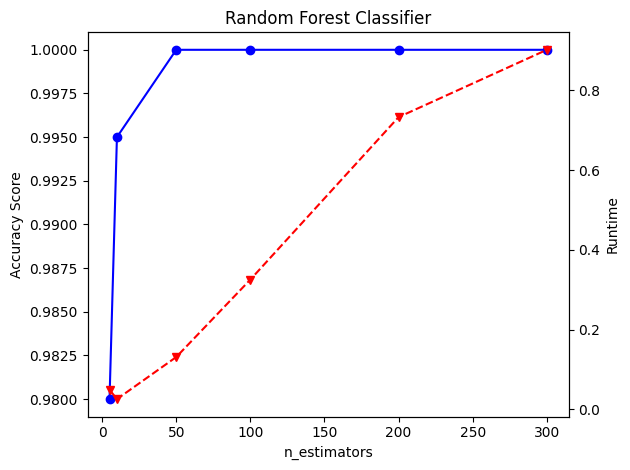

In [ ]:
import time

# กำหนดช่วงค่าต้นไม้ หรือ n_estimators
n_estimators = [5,10,50,100,200,300]

# สร้างโมเดลด้วค่า C ต่างๆ ให้โมเดลเรียนรู้จากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้ แล้วทดสอบโมเดลด้วย accuracy score
accuracy = []
runtimes = []
for n in n_estimators:
    start_time = time.time()  # เริ่มจับเวลา

    # สร้างชุดโมเดล
    clf = RFC(n_estimators=n, random_state=RANDOM_SEED)

    # สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
    clf.fit(x, y)

    runtimes.append((time.time() - start_time)) # หยุดจับเวลา

    # ทำนายค่า y โดยใช้โมเดล
    prediction = clf.predict(x)

    # คำนวณ accuracy score
    accuracy.append(accuracy_score(y, prediction))

# แสดงผล
fig, ax1 = plt.subplots()
ax1.plot(n_estimators, accuracy, 'bo-')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('Accuracy Score')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.plot(n_estimators, runtimes, 'rv--')
#plt.yscale('log')
ax2.set_ylabel('Runtime')

plt.title('Random Forest Classifier')
plt.tight_layout()
plt.show()

การเพิ่มค่า 'n_estimators' หรือจำนวนต้นไม้ ส่งผลให้เพิ่ม computation cost อย่างมีนัยยะสำคัญ  ดังนั้น เราจึงควรเลือกค่า 'n_estimators' ที่ให้ accuracy สูง โดยไม่ใช้เวลาในการพัฒนาโมเดลมากจนเกินไป จากรูปด้านบน เราสามารถเลือกค่า 'n_estimators' = 50 ก็เพียงพอ

Number of Decision Trees: 50


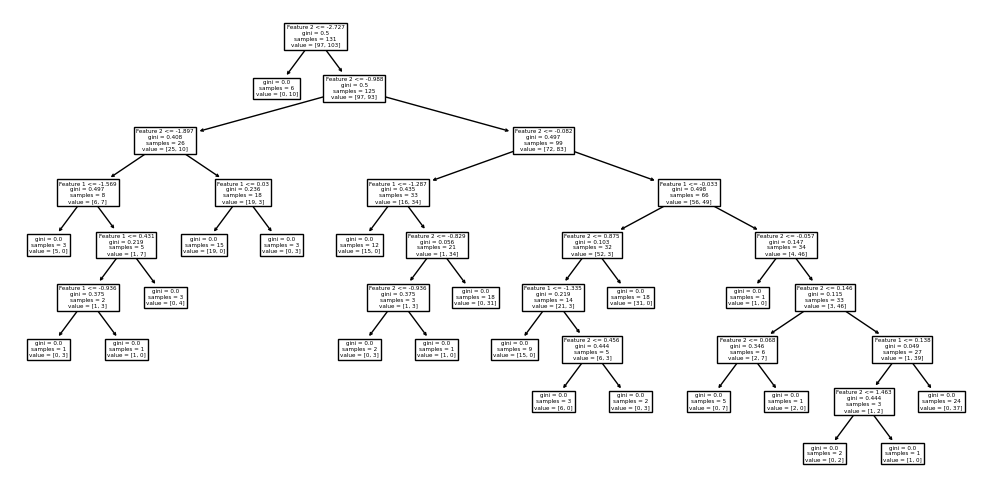

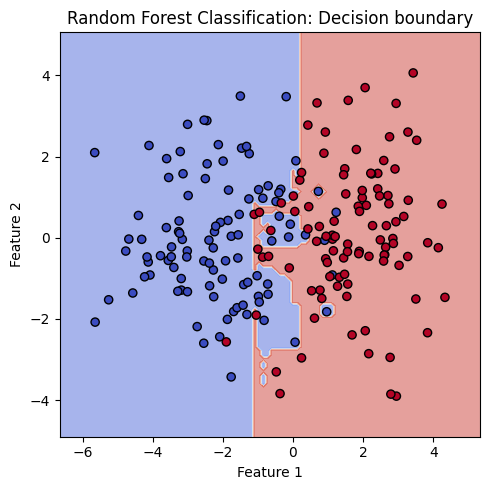

In [ ]:
# สร้างชุดโมเดล
clf = RFC(random_state=RANDOM_SEED, n_estimators=50)

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# แสดงจำนวนต้นไม้
print('Number of Decision Trees:',clf.n_estimators)

# Plot Decision Tree แสดง decision path ของต้นไม้ 1 ต้นแรก
for i in range(1):
    #tree_i = clf.estimators_[i]
    plt.figure(figsize = (10,5))
    tree.plot_tree(clf.estimators_[i],feature_names=['Feature 1','Feature 2'])
plt.tight_layout()
plt.show()

# plot the decision boundary
plt.figure(figsize = (5,5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       response_method="predict",
                                       cmap=plt.cm.coolwarm,
                                       alpha=0.5,
                                       ax=ax,
                                       xlabel='Feature 1',
                                       ylabel='Feature 2'
                                       )
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
plt.title('Random Forest Classification: Decision boundary')
plt.tight_layout()
plt.show()

จะสังเกตได้ว่า decision boundary ยังมีลักษณะค่อนข้าง overfitting นั่นเป็นเพราะโมเดลมี default criteria ให้แตกกิ่งต้นไม้จนกว่า Gini impurity เป็น 0 ต้นไม้จึงมีขนาดใหญ่โดย terminal node มีขนาด samples น้อยมาก  ซึ่งเราสามารถควบคุมขนาดต้นไม้ได้ด้วยการควบคุม hyperparameters เช่น 'max_depth', 'min_samples_split', 'min_samples_leaf' เป็นต้น ซึ่งสามารถศึกษาความหมายเพิ่มเติมได้จากเวปไซส์ของ `scikit-learn` [link](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

โดยในที่นี้เราจะลองควบคุมขนาดต้นไม้ด้วยค่า 'max_depth'

## Random Forest เมื่อปรับค่า 'max_depths' (ความใหญ่ของต้นไม้)

เราสามารถกำหนดจำนวนชั้นของ decision node ได้ด้วยการปรับค่า 'max_depths' ด้วยจำนวนเต็มบวก และ  None

ค่า default ของ 'max_depth' คือ None ซึ่งหมายถึงว่า ต้นไม้จะสร้างเงื่อนไขแตกกิ่งไปจนกว่าข้อมูลในกลุ่มย่อยเป็นคลาสเดียวกันหรือมีค่าเท่ากัน ซึ้งทำให้ต้นไม้มีขนาดใหญ่และเกิด overfitting ได้ง่าย

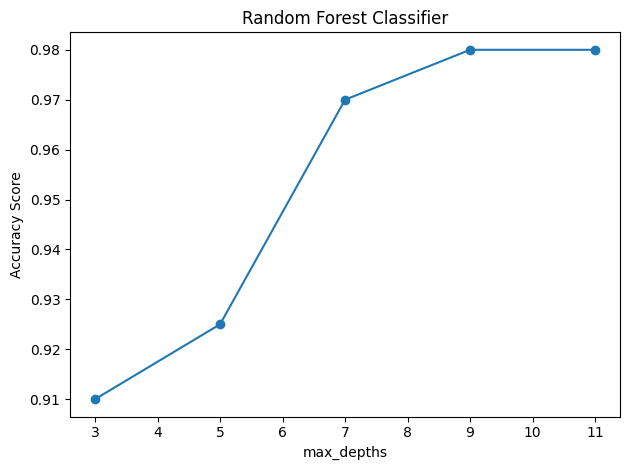

In [ ]:
# กำหนดจำนวนต้นไม้ หรือ n_estimators
n_estimator = 5

# กำหนดความลึก (จำนวนชั้นกิ่ง) สูงสุดของต้นไม้
max_depths = [3,5,7,9,11]

# สร้างโมเดลด้วค่า C ต่างๆ ให้โมเดลเรียนรู้จากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้ แล้วทดสอบโมเดลด้วย accuracy score
accuracy = []
for n in max_depths:
    clf = RFC(n_estimators=n_estimator, max_depth=n, random_state=RANDOM_SEED)
    clf.fit(x, y)

    # ทำนายค่า y โดยใช้โมเดล
    prediction = clf.predict(x)

    # คำนวณ accuracy score
    accuracy.append(accuracy_score(y, prediction))

# แสดงผล
plt.plot(max_depths, accuracy, marker='o')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('max_depths')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Classifier')
plt.tight_layout()
plt.show()

เมื่อ 'max_depths' มีค่าสูงขึ้น ความแม่นยำของโมเดลจะสูงขึ้นด้วย โดยในการสร้างโมเดลนี้ ค่า accuracy เปลี่ยนแปลงน้อยมากเมื่อ 'max_depths' $\ge 9$

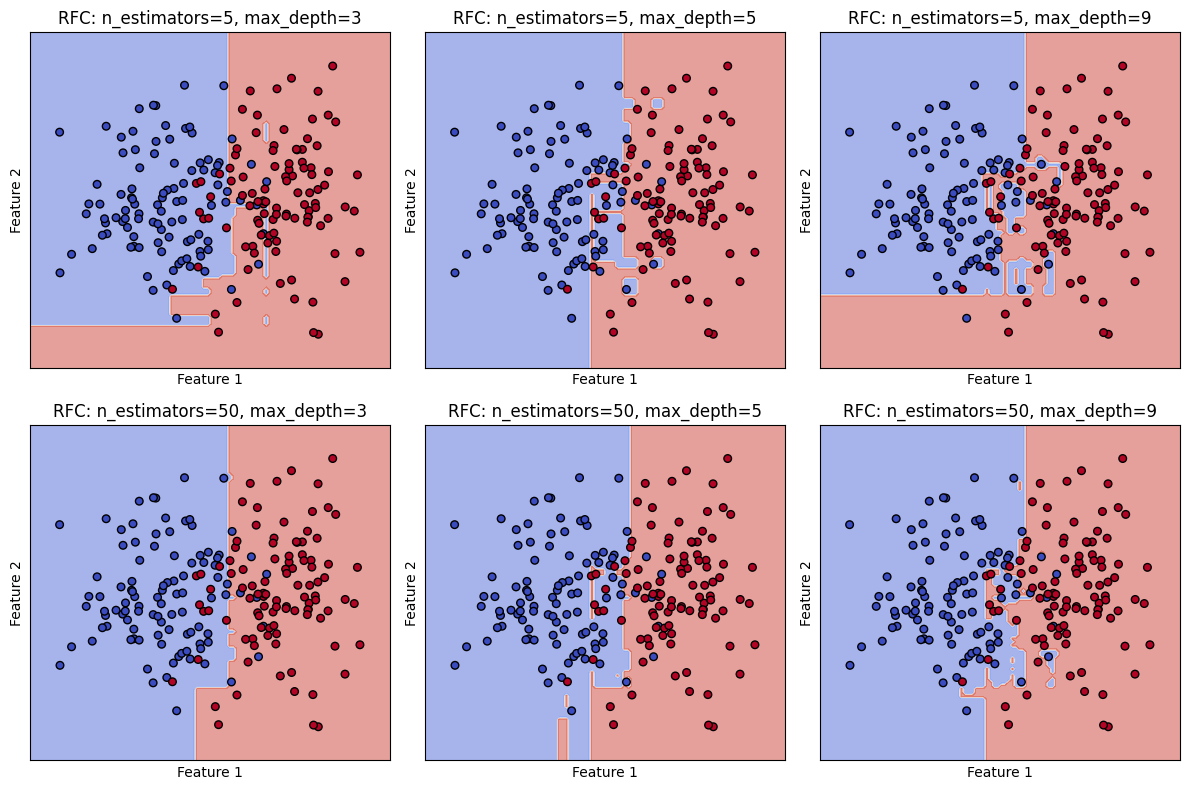

In [ ]:
# สร้างชุดโมเดล
models = (RFC(n_estimators=5, max_depth=3),
          RFC(n_estimators=5, max_depth=5),
          RFC(n_estimators=5, max_depth=9),
          RFC(n_estimators=50, max_depth=3),
          RFC(n_estimators=50, max_depth=5),
          RFC(n_estimators=50, max_depth=9)
          )

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
models = (clf.fit(x, y) for clf in models)

# ตั้งชื่อ plot ที่สอดคล้องกับชุดข้อมูล
titles = ['RFC: n_estimators=5, max_depth=3',
          'RFC: n_estimators=5, max_depth=5',
          'RFC: n_estimators=5, max_depth=9',
          'RFC: n_estimators=50, max_depth=3',
          'RFC: n_estimators=50, max_depth=5',
          'RFC: n_estimators=50, max_depth=9'
          ]

# plot the decision boundaries
fig, axes = plt.subplots(2,3, figsize=(4*3, 4*2))
for clf, title, ax in zip(models, titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=plt.cm.coolwarm,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=30, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

จะเห็นได้ว่า ในขณะที่การใช้ค่า 'n_estimators' สูงสามารถช่วยลดการเกิด overfitting แต่การใช้ค่า 'max_depths' ที่สูงเกินไปจะทำให้เกิด overfitting

เพิ่อลดปัญหา overfitting การปรับค่า 'n_estimators' และ 'max_depths' ควบคู่กันไปจึงมีความสำคัญมาก ดังตัวอย่างด้านล่าง

## RFN Classification pipeline

### Generate 3-class dataset

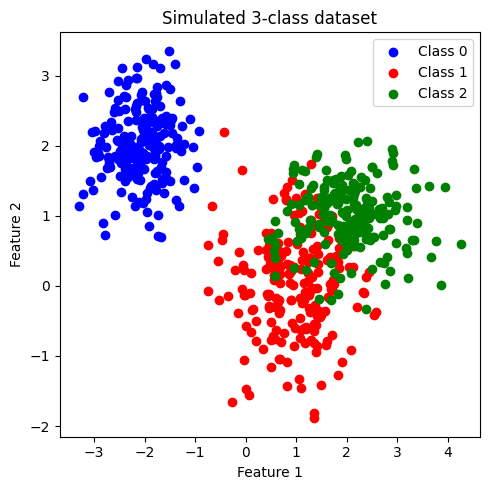

In [ ]:
# สร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 3

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,2], [1,0], [2,1]]
std_class  = [[0.5,0.5], [0.75,0.75],[0.75,0.5]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 200

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่สร้างขึ้น
plt.figure(figsize = (5,5))
color_list = ['b','r','g']
for label in range(n_classes):
    plt.scatter(x[y==label, 0], x[y==label, 1], c=color_list[label], label='Class '+str(label))

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated 3-class dataset')
plt.legend()
plt.tight_layout()
plt.show()


### แบ่งข้อมูลเป็น train-test และ cross-validation
โดยไม่กำกับการแบ่งตามสัดส่วนคลาสของคำตอบ (stratification)

In [ ]:
# สร้าง training data และ test data โดยแบ่งจากชุดข้อมูล x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=None,
                                                    shuffle=True,
                                                    random_state=RANDOM_SEED)

print('Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[  0. 169.]
 [  1. 155.]
 [  2. 156.]]
Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[ 0. 31.]
 [ 1. 45.]
 [ 2. 44.]]


In [ ]:
# แบ่งข้อมูล training data ด้วย 5-fold cross-validation เพื่อ tune hyperparameter
#cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

cv_splitter = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

### ทำการ standardize ข้อมูลทั้งหมด
ใช้ mean และ SD จาก training set ในการ standardize test set เพื่อป้องกัน information leak

In [ ]:
x_scaler = StandardScaler().fit(x_train)

x_train = x_scaler.transform(x_train)
x_test  = x_scaler.transform(x_test)

### เทรนโมเดล ด้วย base model (default hyperparameter)

Training Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       169
         1.0       1.00      1.00      1.00       155
         2.0       1.00      1.00      1.00       156

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       0.80      0.91      0.85        45
         2.0       0.89      0.77      0.83        44

    accuracy                           0.88       120
   macro avg       0.90      0.89      0.89       120
weighted avg       0.89      0.88      0.88       120



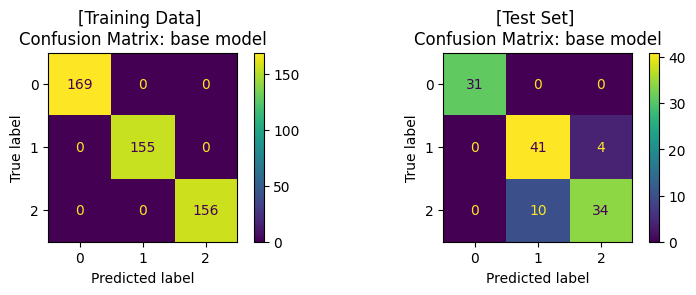

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# สร้างโมเดล
base_clf = RFC(random_state=RANDOM_SEED)

# สอนโมเดลด้วย training data
base_clf.fit(x_train,y_train)

# ให้โมเดลทำนาย training data
y_pred = base_clf.predict(x_train)

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของ training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: base model')

# ให้โมเดลทำนาย test data
y_pred = base_clf.predict(x_test)

# แสดงผล classification ของโมเดล
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))

# คำนวนและแสดงผล confusion matrix ของ test set
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Set] \nConfusion Matrix: base model')

plt.tight_layout()
plt.show()

### ปรับแต่งโมเดล (Hyperparameter Tuning) ด้วย [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) และ train โมเดล

โดยเราจะปรับแต่งโมเดล โดย tune 2 hyperparameters ที่สำคัญของ logistic regression ได้แก่
1. 'n_estimators'
2. 'max_depth'

ในไลบรารี่ `scikit-learn` ยังมีวิธีการอื่นๆ ในการปรับแต่งโมเดล เช่น
- [CrossValScore](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)
- [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)



Best hyperparameters: {'max_depth': 3, 'n_estimators': 100}
Best cross-validation score: 0.90
Training Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       169
         1.0       0.91      0.81      0.86       155
         2.0       0.83      0.92      0.87       156

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.92      0.91      0.91       480


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       0.93      0.84      0.88        45
         2.0       0.85      0.93      0.89        44

    accuracy                           0.92       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.92      0.92      0.92       120



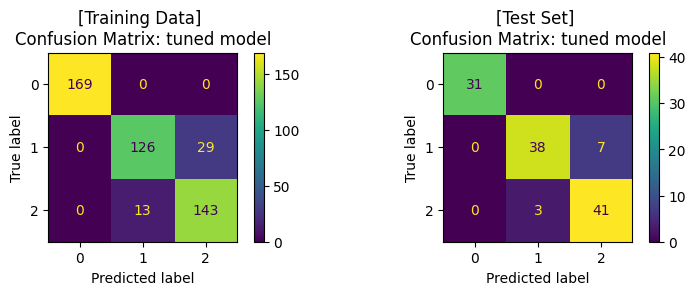

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
clf_params = {'n_estimators': [10,50,100,200],
              'max_depth': [3, 5]
              }

# ใช้ GridSearchCV เพื่อสอนโมเดลจากชุดค่า hyperparameters จาก clf_params
# และคำนวณค่า accuracy ของแต่ละโมเดล เพื่อเลือกชุด hyperparameters ที่ดีที่สุด
# โดยใช้เทคนิค cross-validation ในการแบ่งกลุ่ม validation data จาก training data
tuned_clf = GridSearchCV(estimator=base_clf, param_grid=clf_params,
                             scoring=['accuracy'], refit='accuracy', cv=cv_splitter)

# fit โมเดลด้วย training data และ ให้โมเดลทำนายค่า y จาก training data
tuned_clf.fit(x_train, y_train)
y_pred = tuned_clf.predict(x_train)

# แสดงผล hyperparameters ที่ดีที่สุด และ cross-validation score
print('Best hyperparameters: {}'.format(tuned_clf.best_params_))
print("Best cross-validation score: {:.2f}".format(tuned_clf.best_score_))

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของโมเดลจาก training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: tuned model')

# ให้โมเดลทำนายค่า y จาก test data
y_pred = tuned_clf.predict(x_test)

# แสดงผล classification ของโมเดล จาก test data
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))
# คำนวนและแสดงผล confusion matrix จาก test data
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Set] \nConfusion Matrix: tuned model')

plt.tight_layout()
plt.show()

จะสังเกตได้ว่า เมื่อมีการปรับจูน hyperparameters ของโมเดลให้มีความเหมาะสมแล้ว เราได้โมเดลที่เรียนรู้จากข้อมูลชุดเดิม แล้วสามารถทำนายได้ค่า accuracy ที่สูงขึ้น โดยเมื่อพิจารณา Confusion Matrix จะพบว่า โมเดลสามารถจำแนกข้อมูล class 1 และ class 2 ได้ดีขึ้น

### Feature Importances
โมเดล random forest สามารถคำนวน relative feature importance ของแต่ละ feature ได้ โดยผลรวมของ relative feature importance จะเท่ากับ 1

In [ ]:
# หาค่า feature importances
importances = clf.feature_importances_

# แสดงค่า feature importances
print('Relative Feature Importances:')
print('Feature 1: {:.2f}'.format(importances[0]))
print('Feature 2: {:.2f}'.format(importances[1]))

Relative Feature Importances:
Feature 1: 0.81
Feature 2: 0.19


Feature 1 ค่อนข้างมีความสำคัญอย่างมากในการจำแนกคลาส เมื่อเทียบกับ Feature 2